In [15]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [7]:
satelite = pd.read_csv('Satellite.csv', sep=';')
satelite.head(3)

,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10,...,x.28,x.29,x.30,x.31,x.32,x.33,x.34,x.35,x.36,classes
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,grey soil
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,grey soil
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,grey soil


In [11]:
X = satelite.drop(columns='classes')
y = satelite.classes
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=24, test_size=0.3,stratify=y)

In [12]:
ohe = OneHotEncoder(drop = 'first', sparse_output=False)
ct = make_column_transformer(('passthrough',make_column_selector(dtype_exclude = object)),
                            (ohe, make_column_selector(dtype_include=object)),
                             verbose_feature_names_out=False)

In [13]:
dtc = DecisionTreeClassifier(min_samples_leaf=5,random_state=24)
pipe = Pipeline([('CT',ct),('DTC',dtc)])
pipe.fit(X_train,y_train)

Pipeline(steps=[('CT',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E5E537C440>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E5E537C470>)],
                                   verbose_feature_names_out=False)),
                ('DTC',
                 DecisionTreeClassifier(min_samples_leaf=5, random_state=24))])

In [19]:
params = {  'DTC__min_samples_leaf' : [2,10,25,50],
'DTC__min_samples_split' : [1,10,25,50],
'DTC__max_depth' : [None, 4, 6]}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
gcv = GridSearchCV(pipe, param_grid=params, cv = kfold, verbose=3, scoring='neg_log_loss')
gcv.fit(X,y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END DTC__max_depth=None, DTC__min_samples_leaf=2, DTC__min_samples_split=1;, score=nan total time=   0.0s
[CV 2/5] END DTC__max_depth=None, DTC__min_samples_leaf=2, DTC__min_samples_split=1;, score=nan total time=   0.0s
[CV 3/5] END DTC__max_depth=None, DTC__min_samples_leaf=2, DTC__min_samples_split=1;, score=nan total time=   0.0s
[CV 4/5] END DTC__max_depth=None, DTC__min_samples_leaf=2, DTC__min_samples_split=1;, score=nan total time=   0.0s
[CV 5/5] END DTC__max_depth=None, DTC__min_samples_leaf=2, DTC__min_samples_split=1;, score=nan total time=   0.0s
[CV 1/5] END DTC__max_depth=None, DTC__min_samples_leaf=2, DTC__min_samples_split=10;, score=-3.597 total time=   0.0s
[CV 2/5] END DTC__max_depth=None, DTC__min_samples_leaf=2, DTC__min_samples_split=10;, score=-3.157 total time=   0.0s
[CV 3/5] END DTC__max_depth=None, DTC__min_samples_leaf=2, DTC__min_samples_split=10;, score=-3.864 total time=   0.0s
[CV 4/

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=24, shuffle=True),
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(transformers=[('passthrough',
                                                                         'passthrough',
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001E5E537C440>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001E5E537C470>)],
                                                          verbose_feature_names_out=False)),
                                       ('DTC',
                                        DecisionTreeClassifier(min_samples_leaf=5,
                                                               random_state=24))]),
             param_grid={'DTC__max_depth': [None, 4, 6],
                         'DTC__min_samples_leaf': [2, 10, 25, 50],
                         'DTC__min_samples_split': [1, 10, 25, 50]},
             scoring='neg_log_loss', verbose=3)

In [20]:
print(gcv.best_score_)
print(gcv.best_params_)

-0.6679631827034694
{'DTC__max_depth': 4, 'DTC__min_samples_leaf': 50, 'DTC__min_samples_split': 10}


In [21]:
best_tree_model = gcv.best_estimator_.named_steps['DTC']

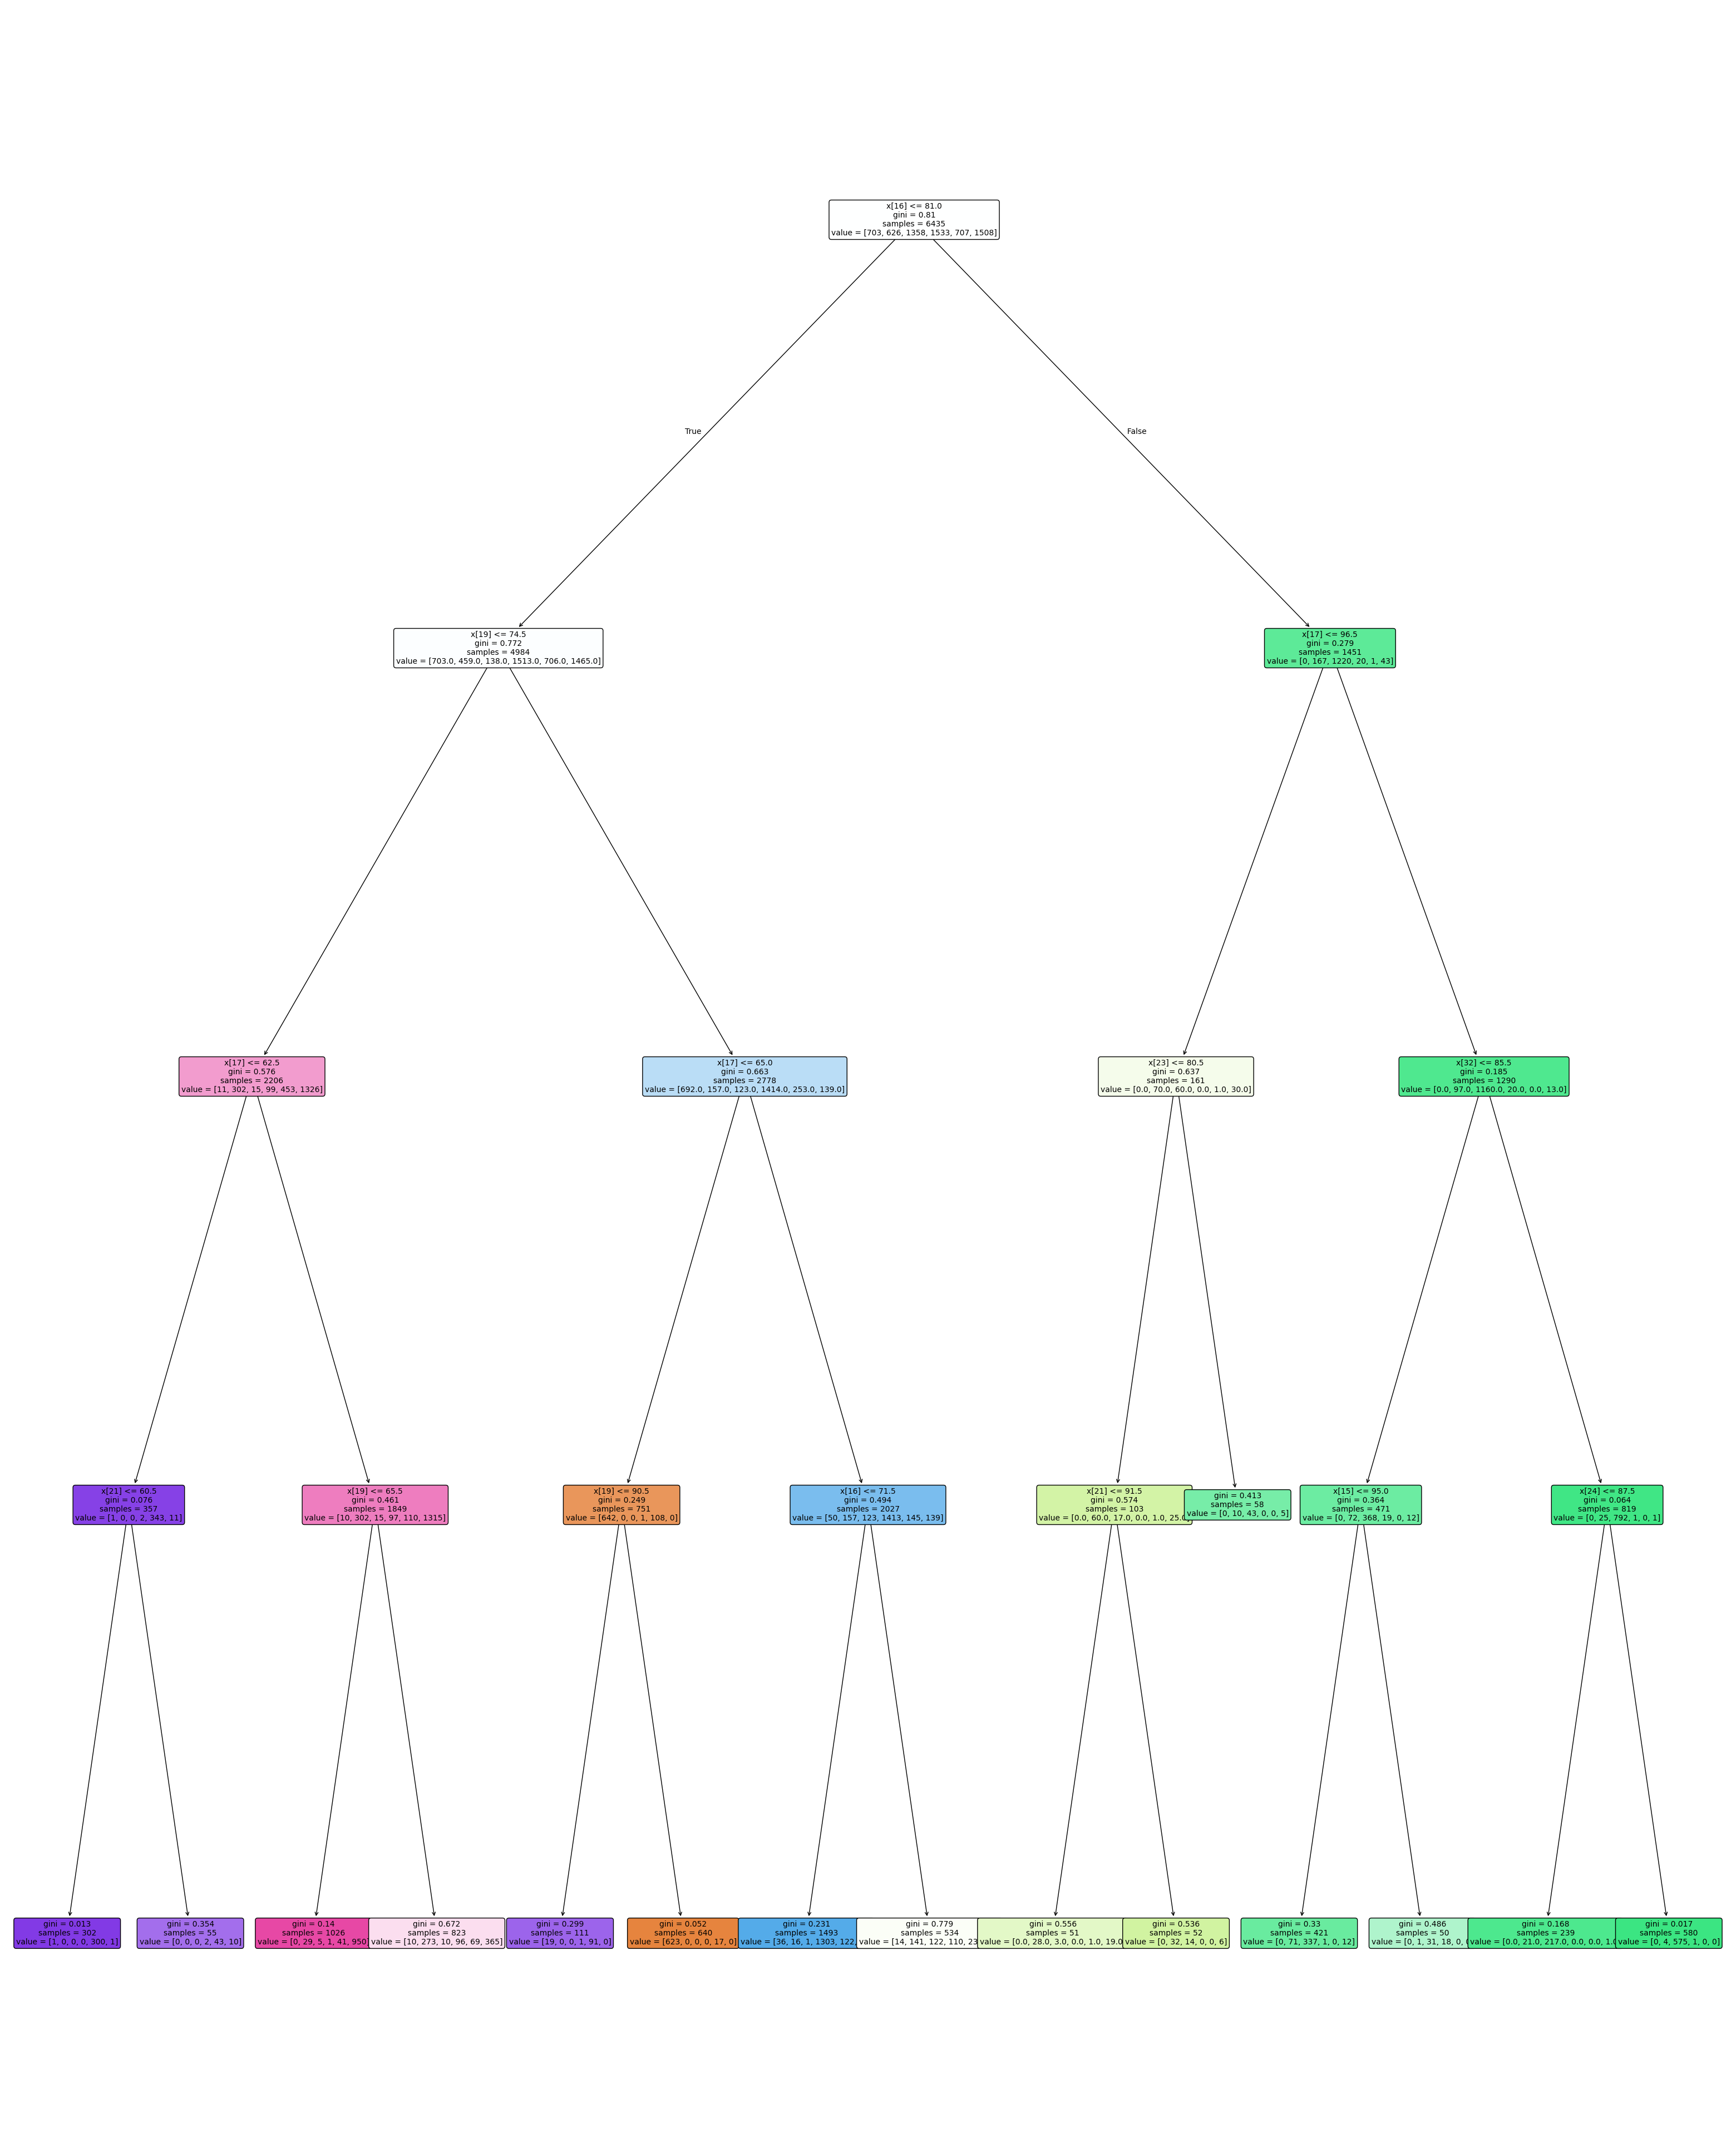

In [22]:
plt.figure(figsize=(40,50))
plot_tree(best_tree_model, 
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.show()

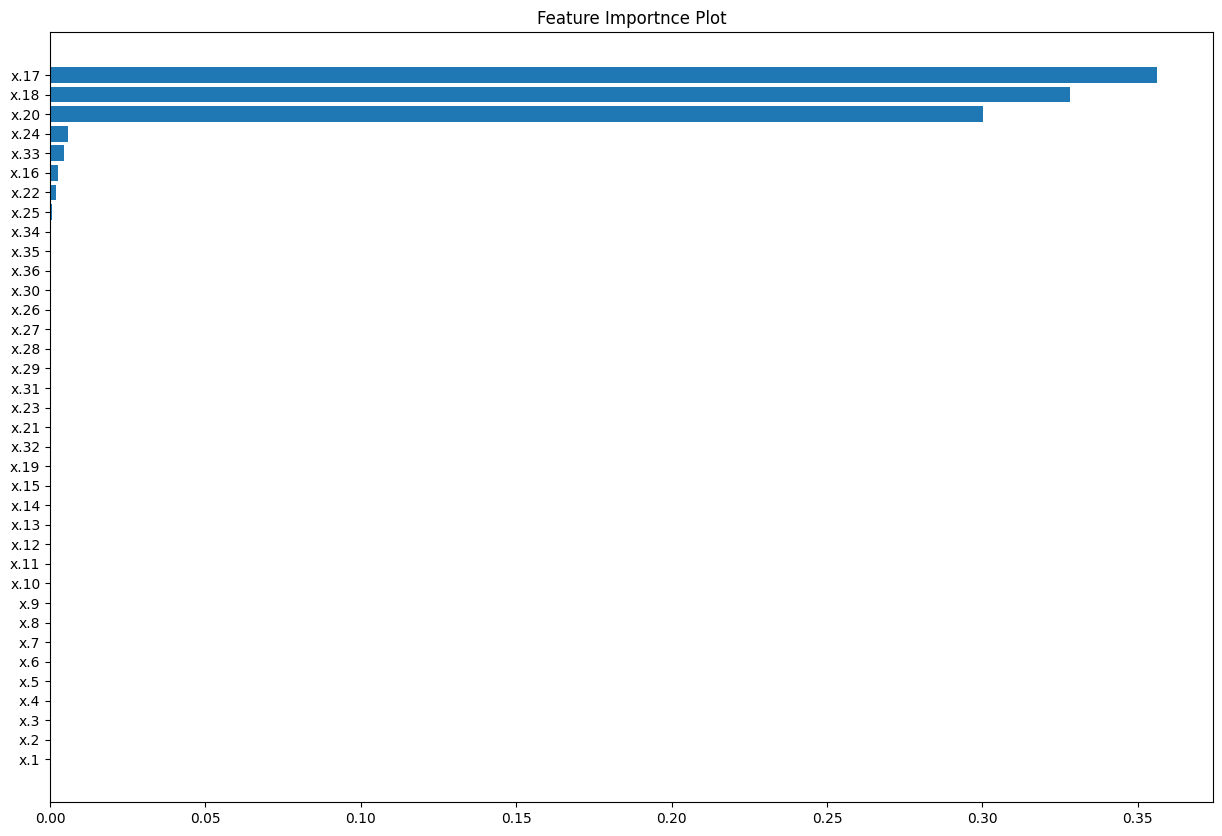

In [23]:
satelite_imp = pd.DataFrame({'feature': list(gcv.best_estimator_.named_steps['CT'].get_feature_names_out()),
                      'importance':best_tree_model.feature_importances_})
satelite_imp.sort_values('importance', inplace=True)
plt.figure(figsize=(15,10))
plt.barh(satelite_imp['feature'], satelite_imp['importance'])
plt.title("Feature Importnce Plot")
plt.show()